# Game Finish Analysis

## This notebook does a deep dive into the final few minutes of a NFL football game and what factors are most influential in determine whether a team is going to win.

In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm 
from statsmodels.api import Logit


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
nfl_data = pd.read_csv('NFL Play by Play 2009-2018.csv')

In [4]:
nfl_data.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
teams_mapping = {}
for team in nfl_data['home_team'].unique():
    if team == 'STL':
        teams_mapping[team] = 'LA'
    elif team == 'SD':
        teams_mapping[team] = 'LAC'
    elif team == 'JAC':
        teams_mapping[team] = 'JAX'
    else:
        teams_mapping[team] = team
teams_mapping

{'PIT': 'PIT',
 'CLE': 'CLE',
 'NO': 'NO',
 'TB': 'TB',
 'HOU': 'HOU',
 'IND': 'IND',
 'CIN': 'CIN',
 'CAR': 'CAR',
 'BAL': 'BAL',
 'ATL': 'ATL',
 'ARI': 'ARI',
 'SEA': 'SEA',
 'NYG': 'NYG',
 'GB': 'GB',
 'NE': 'NE',
 'OAK': 'OAK',
 'DET': 'DET',
 'WAS': 'WAS',
 'TEN': 'TEN',
 'PHI': 'PHI',
 'NYJ': 'NYJ',
 'KC': 'KC',
 'JAC': 'JAX',
 'SF': 'SF',
 'BUF': 'BUF',
 'SD': 'LAC',
 'DEN': 'DEN',
 'CHI': 'CHI',
 'DAL': 'DAL',
 'MIA': 'MIA',
 'MIN': 'MIN',
 'STL': 'LA',
 'LA': 'LA',
 'JAX': 'JAX',
 'LAC': 'LAC'}

In [6]:
for col in [col for col in nfl_data.columns if col.endswith('team')]:
    nfl_data[col] = nfl_data[col].map(teams_mapping)

In [7]:
trimmed_df = nfl_data[['play_id','game_id','home_team','away_team','posteam','posteam_type'
          ,'yardline_100','play_type', 'game_half'
          ,'down','yrdln','ydstogo','game_seconds_remaining'
          ,'timeout','timeout_team'
          ,'posteam_timeouts_remaining','defteam_timeouts_remaining'
          ,'posteam_score','defteam_score', 'total_home_score','total_away_score'
          ]]
trimmed_df.drop_duplicates(inplace = True)
trimmed_df['Season'] = trimmed_df.game_id.apply(lambda x: int(str(x)[:4]))
trimmed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,yardline_100,play_type,game_half,down,...,game_seconds_remaining,timeout,timeout_team,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,total_home_score,total_away_score,Season
0,46,2009091000,PIT,TEN,PIT,home,30.0,kickoff,Half1,NaN,...,3600.0,0.0,NaN,3.0,3.0,NaN,NaN,0,0,2009
1,68,2009091000,PIT,TEN,PIT,home,58.0,pass,Half1,1.0,...,3593.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2009
2,92,2009091000,PIT,TEN,PIT,home,53.0,run,Half1,2.0,...,3556.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2009
3,113,2009091000,PIT,TEN,PIT,home,56.0,pass,Half1,3.0,...,3515.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2009
4,139,2009091000,PIT,TEN,PIT,home,56.0,punt,Half1,4.0,...,3507.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2009


In [8]:
trimmed_df['play_type'].fillna('NONE', inplace = True)
trimmed_df = trimmed_df[~trimmed_df['play_type'].isin(['kickoff','extra_point','NONE'])].sort_values(['game_id','play_id']).copy()
trimmed_df = trimmed_df[trimmed_df['Season'] >= 2014].copy()
trimmed_df.reset_index(inplace = True)
trimmed_df.drop('index', axis = 1, inplace = True)
trimmed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,yardline_100,play_type,game_half,down,...,game_seconds_remaining,timeout,timeout_team,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,total_home_score,total_away_score,Season
0,58,2014090400,SEA,GB,GB,away,87.0,run,Half1,1.0,...,3596.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2014
1,79,2014090400,SEA,GB,GB,away,81.0,no_play,Half1,2.0,...,3570.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2014
2,111,2014090400,SEA,GB,GB,away,76.0,run,Half1,1.0,...,3551.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2014
3,132,2014090400,SEA,GB,GB,away,61.0,run,Half1,1.0,...,3512.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2014
4,153,2014090400,SEA,GB,GB,away,59.0,pass,Half1,2.0,...,3486.0,0.0,NaN,3.0,3.0,0.0,0.0,0,0,2014


In [9]:
# We only want to look at games where there was a winner in regulation. I could have left in games that went into
# overtime or ended in a tie, but I wanted to keep it simple for this analysis

def game_winner(row):
    home_team = row['home_team']
    away_team = row['away_team']
    home_score = row['total_home_score']
    away_score = row['total_away_score']
    
    if home_score > away_score:
        return home_team
    elif home_score < away_score:
        return away_team
    else:
        return np.nan

game_results = trimmed_df[['game_id','game_half','home_team','away_team','total_home_score','total_away_score']]
game_results['Overtime'] = game_results.game_half.apply(lambda x: 1 if x == 'Overtime' else 0)
game_results.drop('game_half', axis = 1, inplace = True)
game_results = game_results.groupby(['game_id','home_team','away_team'],as_index = False).max()
game_results['Winning Team'] = game_results.apply(game_winner, axis = 1)
game_results = game_results[['game_id','home_team','away_team','Overtime','Winning Team']]
game_results

,game_id,home_team,away_team,Overtime,Winning Team
0,2014090400,SEA,GB,0,SEA
1,2014090700,ATL,NO,1,ATL
2,2014090701,BAL,CIN,0,CIN
3,2014090702,CHI,BUF,1,BUF
4,2014090703,HOU,WAS,0,HOU
5,2014090704,KC,TEN,0,TEN
6,2014090705,MIA,NE,0,MIA
7,2014090706,NYJ,OAK,0,NYJ
8,2014090707,PHI,JAX,0,PHI
9,2014090708,PIT,CLE,0,PIT


In [10]:
trimmed_df = pd.merge(trimmed_df, game_results)
trimmed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,yardline_100,play_type,game_half,down,...,timeout_team,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,total_home_score,total_away_score,Season,Overtime,Winning Team
0,58,2014090400,SEA,GB,GB,away,87.0,run,Half1,1.0,...,NaN,3.0,3.0,0.0,0.0,0,0,2014,0,SEA
1,79,2014090400,SEA,GB,GB,away,81.0,no_play,Half1,2.0,...,NaN,3.0,3.0,0.0,0.0,0,0,2014,0,SEA
2,111,2014090400,SEA,GB,GB,away,76.0,run,Half1,1.0,...,NaN,3.0,3.0,0.0,0.0,0,0,2014,0,SEA
3,132,2014090400,SEA,GB,GB,away,61.0,run,Half1,1.0,...,NaN,3.0,3.0,0.0,0.0,0,0,2014,0,SEA
4,153,2014090400,SEA,GB,GB,away,59.0,pass,Half1,2.0,...,NaN,3.0,3.0,0.0,0.0,0,0,2014,0,SEA


In [11]:
def win_flag(row):
    return 1 if row['posteam'] == row['Winning Team'] else 0
def score_difference(row):
    return row['posteam_score'] - row['defteam_score']

final_df = trimmed_df[['game_id', 'home_team', 'away_team', 'posteam',
       'posteam_type', 'yardline_100', 'play_type', 'down',
        'game_seconds_remaining',
       'ydstogo', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'posteam_score',
       'defteam_score','Overtime', 'Winning Team']]
final_df = final_df[(final_df['play_type'] != 'no_play') & (final_df['Overtime'] == 0)].copy()
final_df['Score Difference'] = final_df.apply(score_difference, axis = 1)
final_df['Win'] = final_df.apply(win_flag, axis = 1)
final_df.drop(['play_type','Overtime','Winning Team','home_team','away_team','game_id','posteam','posteam_score','defteam_score'], axis = 1, inplace = True)
final_df.dropna(inplace = True)

# Logistic Regression Results

I wanted to look at models at the increments (in seconds) 100, 200, 300, 400, 500 left in the game to determine if the parameters changed over time and which ones became more influential as the game grew closer to an end.

In [13]:
r_squared_values = []
yardline_100_list = []
down_list = []
game_seconds_remaining_list = []
ydstogo_list = []
posteam_timeouts_remaining_list = []
defteam_timeouts_remaining_list = []
Score_Difference_list = []
posteam_type_home_list = []

times = np.arange(100,600, 100)

# Creates a logistic regression analysis and puts the parameters in their respected lists
# This way we can see how parameters shift over time
for time in times:
    end_game_df = final_df[(final_df['game_seconds_remaining'] <= time)].copy()
    data = pd.get_dummies(end_game_df)
    data.drop('posteam_type_away', axis = 1, inplace = True)
    X = sm.add_constant(data[[col for col in data.columns if col != 'Win']])
    y = data[['Win']]
    results = Logit(y, X).fit()
    r_squared_values.append(results.prsquared)
    for param in [param for param in results.bse.index if param != 'const']:
        globals()[param.replace(' ','_') + '_list'].append(results.tvalues[param])

Optimization terminated successfully.
         Current function value: 0.152120
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.185816
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.195549
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.204262
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.216513
         Iterations 9


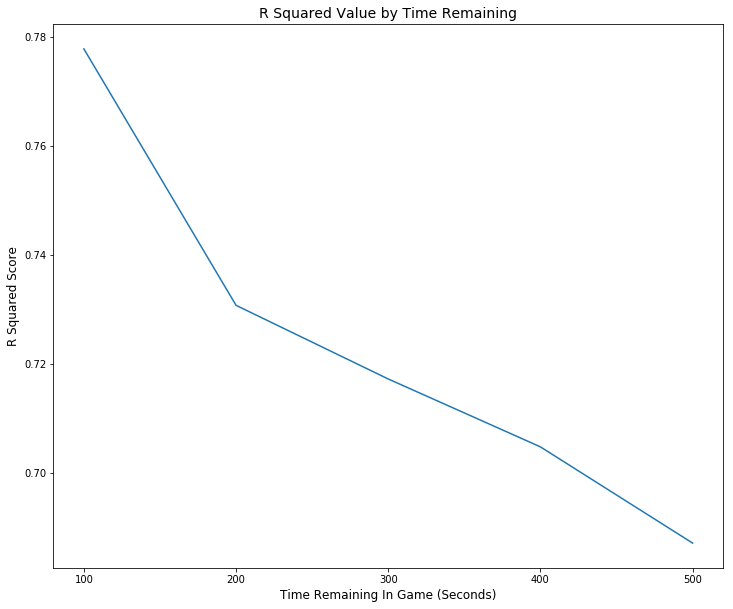

In [15]:
# The R^2 plot for each model.

plt.figure(figsize = (12,10))
plt.plot(times, r_squared_values)
plt.xticks(times, fontsize = 10)
plt.xlabel('Time Remaining In Game (Seconds)', fontsize = 12)
plt.ylabel('R Squared Score', fontsize = 12)
plt.title('R Squared Value by Time Remaining', fontsize = 14);

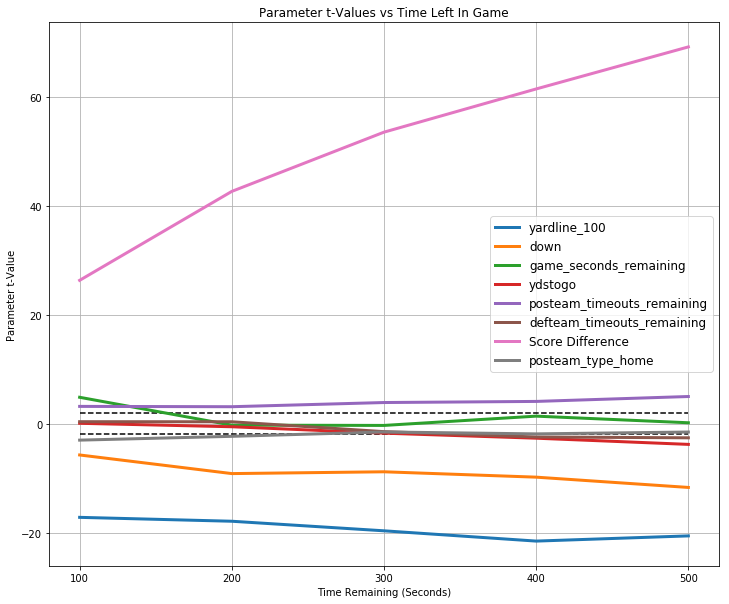

In [16]:
# Plot that showed how the parameters changed over time for each model

plt.figure(figsize = (12,10))
for param in [param for param in results.bse.index if param != 'const']:
    plt.plot(times,globals()[param.replace(' ','_') + '_list'], label = param, linewidth = 3)
plt.legend(fontsize = 12)
plt.title('Parameter t-Values vs Time Left In Game')
plt.xticks(times, fontsize = 10)
plt.ylabel('Parameter t-Value')
plt.xlabel('Time Remaining (Seconds)')
plt.hlines(1.96, 100, 500, color = 'black', linestyles='dashed')
plt.hlines(-1.96, 100, 500, color = 'black', linestyles='dashed')
plt.grid();

# How to interpret logistic regression

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

In [18]:
# The logistic regression model output for the last 100 seconds left in the game

end_game_df = final_df[(final_df['game_seconds_remaining'] <= 100)].copy()
data = pd.get_dummies(end_game_df)
data.drop('posteam_type_away', axis = 1, inplace = True)
X = sm.add_constant(data[[col for col in data.columns if col != 'Win']])
y = data[['Win']]
results = Logit(y, X).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.152120
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 6029
Model:                          Logit   Df Residuals:                     6020
Method:                           MLE   Df Model:                            8
Date:                Sun, 18 Aug 2019   Pseudo R-squ.:                  0.7778
Time:                        11:17:55   Log-Likelihood:                -917.13
converged:                       True   LL-Null:                       -4127.2
                                        LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.2068      0.303     13.879      0.000       3.613       4.801
yardline_100                  -0.0545      0.003    -17.199      0.000      -0.061      -0.048
down                          -0.3645      0.064     -5.731      0.000      -0.489      -0.240
game_seconds_remaining         0.0120      0.002      4.876      0.000       0.007       0.017
ydstogo                        0.0015      0.016      0.092      0.926      -0.031       0.034
posteam_timeouts_remaining     0.2061      0.064      3.201      0.001       0.080       0.332
defteam_timeouts_remaining     0.0241      0.062      0.387      0.699      -0.098       0.146
Score Difference               0.8371      0.032     26.377      0.000       0.775       0.899
posteam_type_home             -0.3611      0.120     -3.003      0.003      -0.597      -0.125
==============================================================================================

Possibly complete quasi-separation: A fraction 0.35 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [17]:
# Change in odds for posteam_timeouts_remaining
np.exp(.2061)-1

0.2288760854596823